<a href="https://colab.research.google.com/github/B21-CAP0133/verify-android-app/blob/master/ML-dir/07_VERIFY_Build_tf_Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from tensorflow.keras.optimizers import Adam
import pickle
import matplotlib.pyplot as plt
import pathlib

import tensorflow_hub as hub

In [2]:
df = pd.read_csv('verify_dataset_clean.csv')
df.sample(5)

,Judul,Label
6006,ketua pssi terima kasih atas abdi ratu tisha,0
2528,pesan beranta taman raya tahap v zona merah co...,1
219,prof tokuda terseyum lihat data curang kpu,1
1952,foto robek bakar kencing alquran wanita langsu...,1
3128,baju adat tiongkok china gambar uang pecah 75 ...,1


In [3]:
x_train_text, x_test_text, y_train, y_test = train_test_split(df['Judul'], df['Label'], test_size=0.1)

In [4]:
vectorizer = CountVectorizer(
    ngram_range = (1, 2),
    decode_error = 'replace',
    max_df = 0.5,
    max_features = None
)

pickle.dump(vectorizer.vocabulary, open('fitur.pkl', 'wb'))

In [5]:
transformer = TfidfTransformer(
    norm = 'l2',
    use_idf = True
)

In [6]:
x_train = transformer.fit_transform(vectorizer.fit_transform(np.array(x_train_text))).toarray()
x_test = transformer.transform(vectorizer.transform(np.array(x_test_text))).toarray()

In [7]:
x_train.shape, x_test.shape

((6549, 41479), (728, 41479))

In [8]:
len(y_train), len(y_test)

(6549, 728)

In [9]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(1, input_shape=(x_train.shape[1],), activation='sigmoid'),
])

model.summary()

opt = Adam()
model.compile(optimizer = opt,
              loss = 'binary_crossentropy',
              metrics = ['accuracy']
              )

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 41480     
Total params: 41,480
Trainable params: 41,480
Non-trainable params: 0
_________________________________________________________________


In [10]:
history = model.fit(x_train, y_train,
                    validation_data = (x_test, y_test),
                    epochs = 50,
                    shuffle = True
                    )

Epoch 1/50
205/205 [==============================] - 5s 7ms/step - loss: 0.6888 - accuracy: 0.5628 - val_loss: 0.6719 - val_accuracy: 0.5907
Epoch 2/50
205/205 [==============================] - 1s 5ms/step - loss: 0.6625 - accuracy: 0.5777 - val_loss: 0.6545 - val_accuracy: 0.6044
Epoch 3/50
205/205 [==============================] - 1s 5ms/step - loss: 0.6358 - accuracy: 0.6149 - val_loss: 0.6395 - val_accuracy: 0.6250
Epoch 4/50
205/205 [==============================] - 1s 5ms/step - loss: 0.6123 - accuracy: 0.6809 - val_loss: 0.6258 - val_accuracy: 0.6511
Epoch 5/50
205/205 [==============================] - 1s 5ms/step - loss: 0.5876 - accuracy: 0.7529 - val_loss: 0.6130 - val_accuracy: 0.7143
Epoch 6/50
205/205 [==============================] - 1s 5ms/step - loss: 0.5693 - accuracy: 0.8151 - val_loss: 0.6011 - val_accuracy: 0.7335
Epoch 7/50
205/205 [==============================] - 1s 5ms/step - loss: 0.5500 - accuracy: 0.8635 - val_loss: 0.5897 - val_accuracy: 0.7500
Epoch 

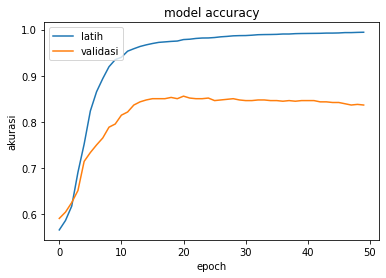

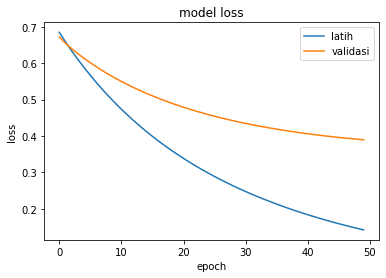

In [11]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('akurasi')
plt.xlabel('epoch')
plt.legend(['latih', 'validasi'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['latih', 'validasi'], loc='upper right')
plt.show()

In [12]:
model.save('verify_model.h5')

# Saved to TFLite

In [13]:
export_dir = '/content/'

tf.saved_model.save(model, export_dir)

INFO:tensorflow:Assets written to: /content/assets


In [14]:
mode = "Speed" 

if mode == 'Storage':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
    optimization = tf.lite.Optimize.DEFAULT

In [15]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)

converter.optimizations = [optimization]

tflite_model = converter.convert()

In [18]:
tflite_model_file = pathlib.Path('./verify_model.tflite')
tflite_model_file.write_bytes(tflite_model)

42688